In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from utils.preprocessing import preprocessing
from utils.scores import display_silhouettes, display_scores_ms
from utils.display import display_clusters

# 1/ Dataset upload/overview

In [3]:
df = pd.read_csv("../data/kaya_dataset.csv")
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              7745 non-null   object 
 1   year                 7745 non-null   int64  
 2   iso_code             7745 non-null   object 
 3   co2                  7745 non-null   float64
 4   energy               7745 non-null   float64
 5   gdp                  7745 non-null   float64
 6   population           7745 non-null   float64
 7   co2_per_unit_energy  7745 non-null   float64
 8   energy_per_gdp       7745 non-null   float64
 9   gdp_per_capita       7745 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 605.2+ KB
None


,year,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
count,7745.000000,7745.000000,7.745000e+03,7.745000e+03,7.745000e+03,7745.000000,7745.000000,7745.000000
mean,1997.914009,169.430360,7.407782e+11,4.259151e+11,4.002676e+07,0.239455,1.674191,13025.601709
std,15.104324,683.710379,2.786040e+12,1.488989e+12,1.350935e+08,0.200058,1.631089,14718.564983
min,1965.000000,0.022000,9.765923e+07,1.642060e+08,6.408200e+04,0.018000,0.078000,361.188725
25%,1986.000000,3.691000,1.850453e+10,1.803369e+10,3.593782e+06,0.186000,0.767000,2808.878751
50%,1999.000000,20.870000,8.890039e+10,6.434611e+10,9.754398e+06,0.221000,1.245000,7828.856656
75%,2011.000000,84.838000,4.128210e+11,2.542891e+11,2.810118e+07,0.261000,2.053000,18309.742796
max,2022.000000,11711.808000,4.451869e+13,2.696602e+13,1.426437e+09,10.689000,25.253000,163531.400281


# 2/ data and feature selection

In [13]:
# countries selection :
countries = df.country.unique()
# year selection :
# years = df.year.unique()
years = [2022]  # only 2022
# common columns :
# cols = df.columns.tolist() # select all
cols = ['country', 'year', 'iso_code']
# features selection :
features_1 = ['co2', 'energy', 'gdp', 'population']
features_2 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita']
features_3 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population']
features = features_2

# bandwidth parameters
# bw_values = [2.2, 2.25, 2.3, 2.35, 2.4, 2.45]
bw_values = [1.4, 1.5, 1.6, 1.8, 2.2, 2.3, 2.35]

rs = 42 # seed for random functions (center first position)

# 3/ Results

In [14]:
# check rapide :
df, X =  preprocessing(df, years, countries, cols, features)
bw = estimate_bandwidth(X, quantile=0.1)

ms = MeanShift(bandwidth=bw)
cluster_labels = ms.fit_predict(X)
centers = ms.cluster_centers_

n_clusters = len(set(cluster_labels) - {-1})
if n_clusters > 0 and n_clusters < X.shape[0]:
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_sample_values = silhouette_samples(X, cluster_labels)
else:
    silhouette_avg = 0
    silhouette_sample_values = np.zeros(cluster_labels.shape)

print("Nombre de points : ", X.shape[0])
print("Bandwidth estimé:", round(float(bw), 4))
print("Nombre de clusters: ", centers.shape[0])
print("Score silhouette : ", silhouette_avg)


# fig1 = display_silhouettes(X, n_clusters, cluster_labels)
# fig2 = display_clusters(X, n_clusters, features, centers, cluster_labels, dfl['population'])


Nombre de points :  164
Bandwidth estimé: 1.0169
Nombre de clusters:  12
Score silhouette :  0.26018196605832367


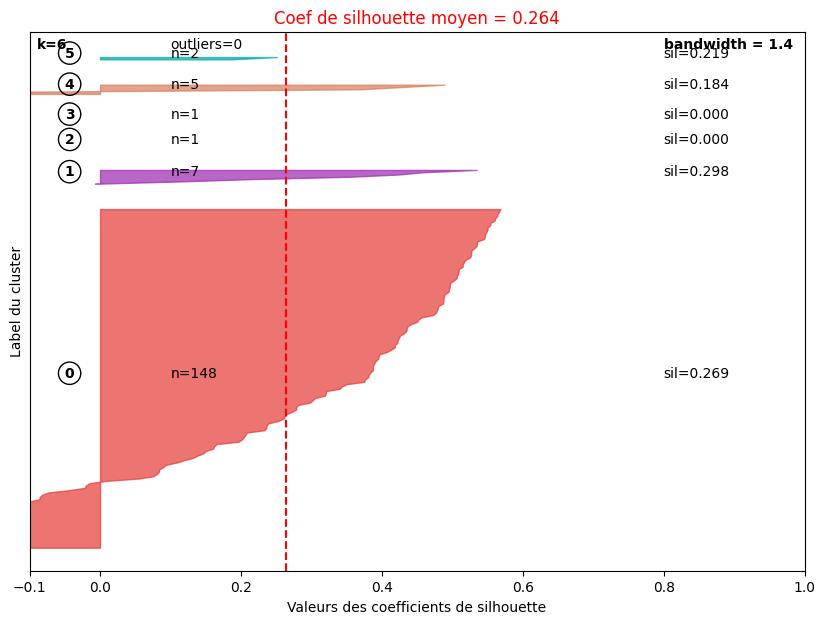

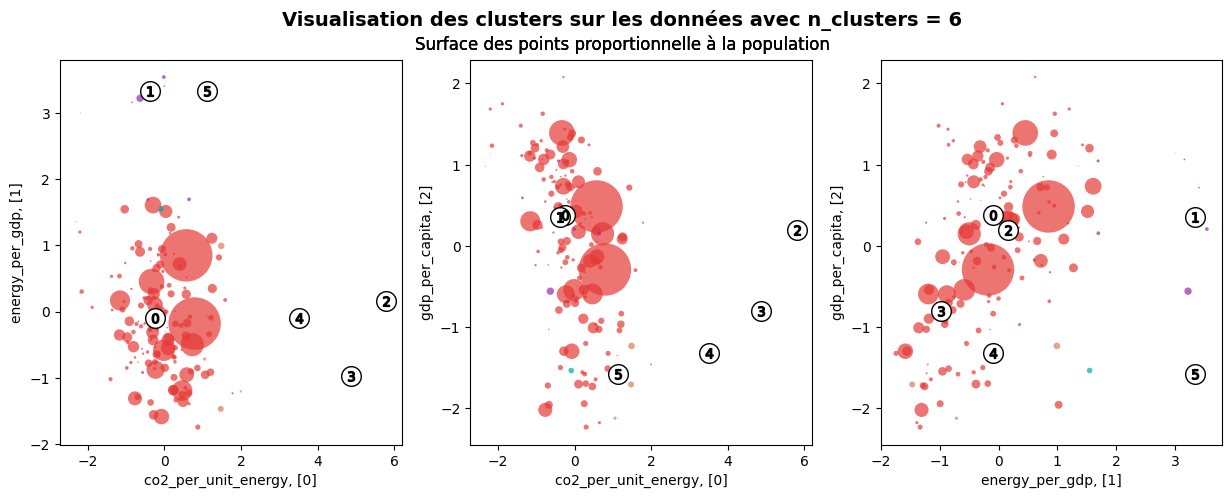

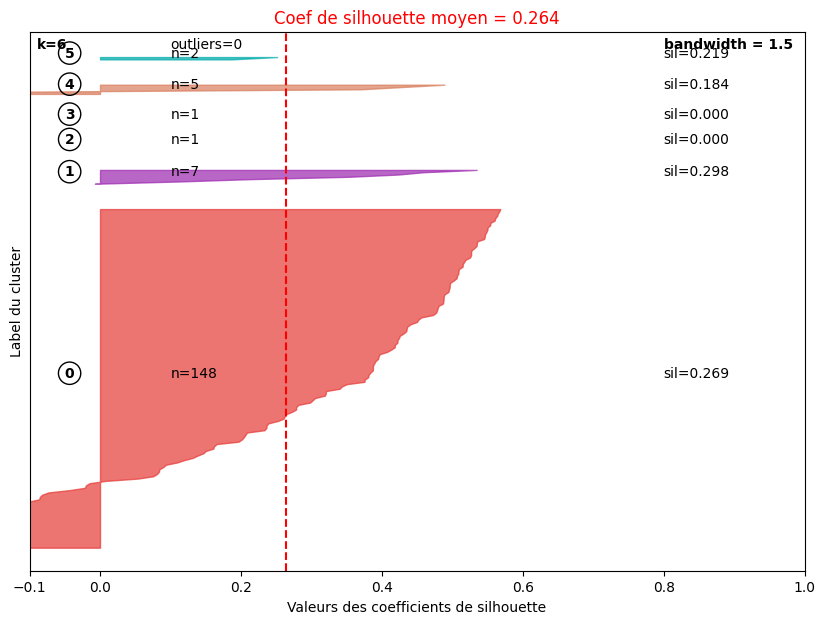

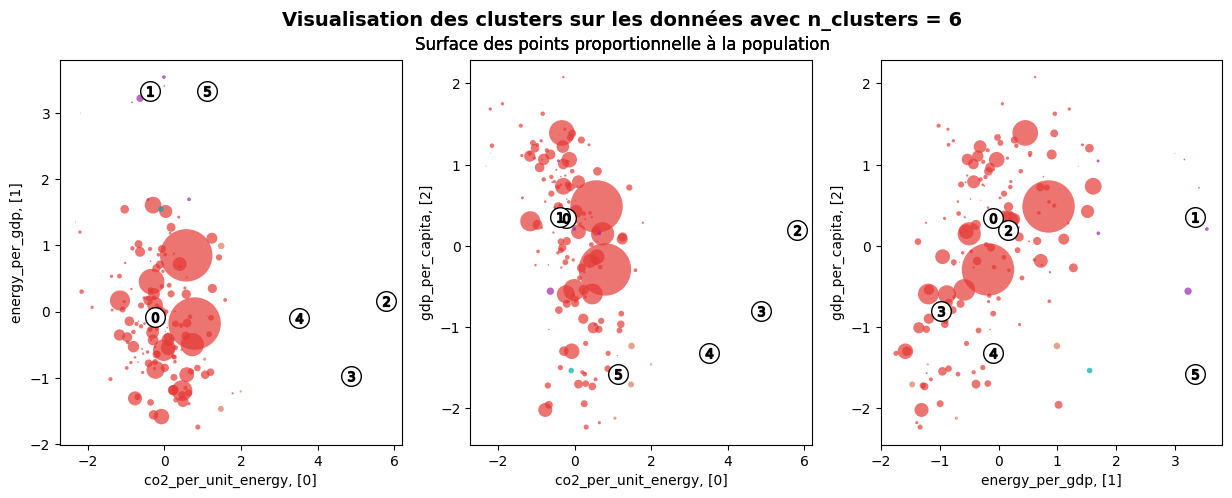

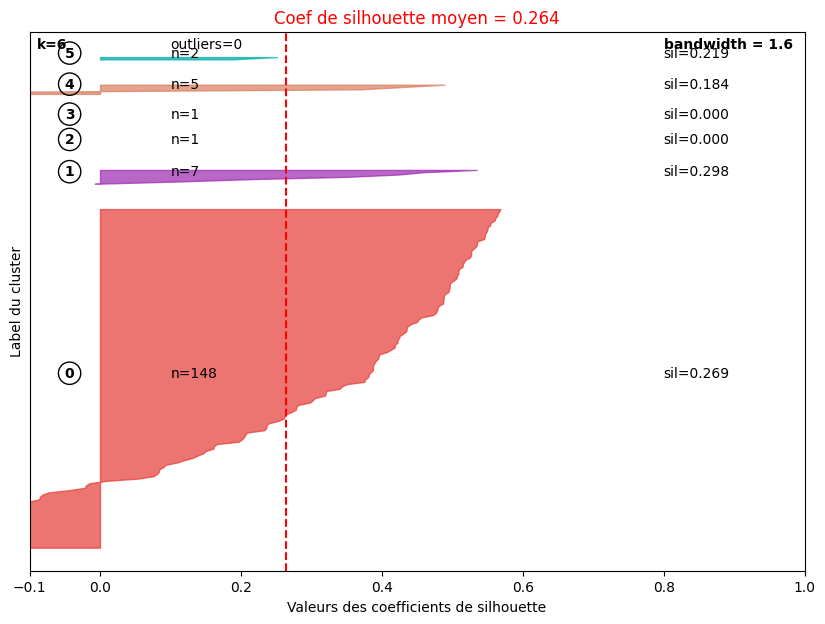

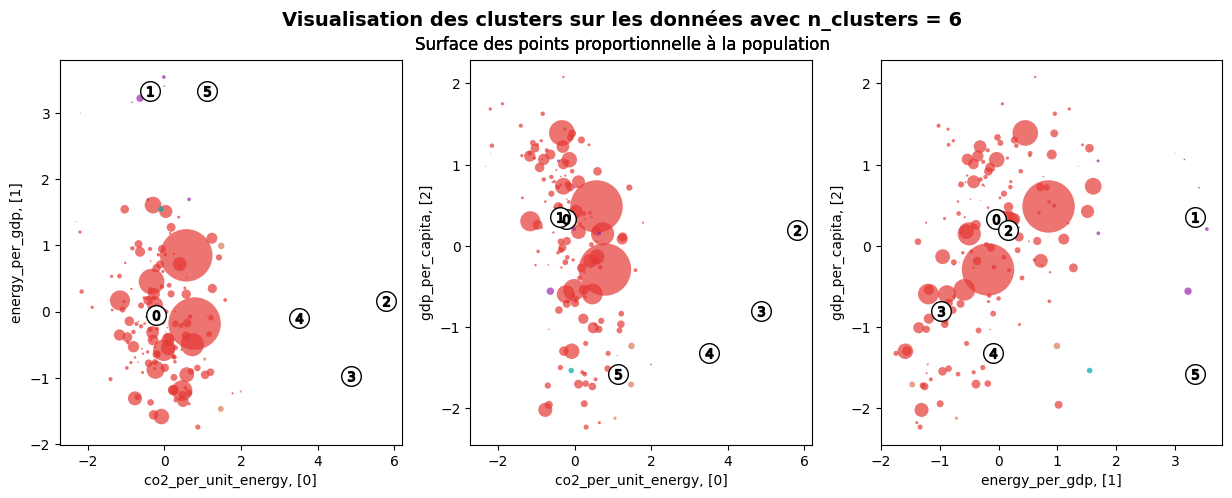

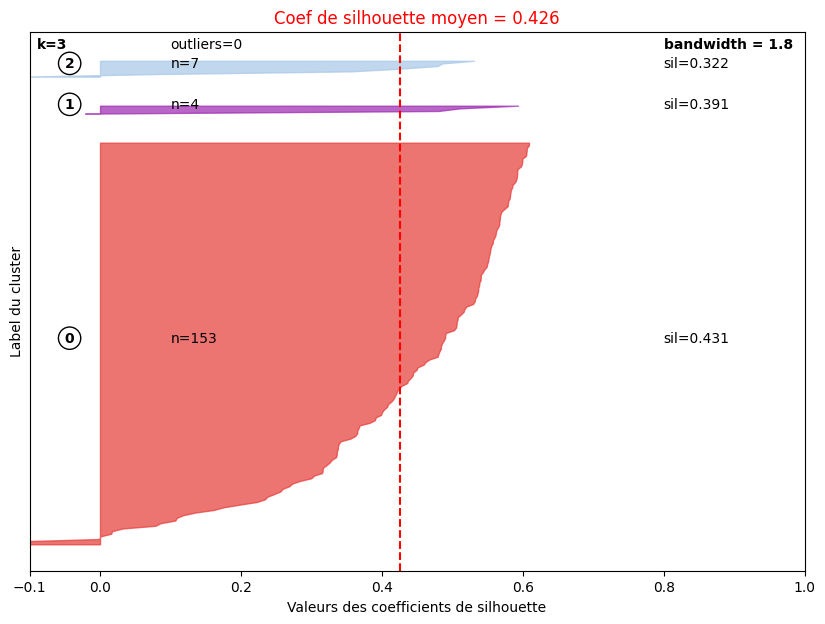

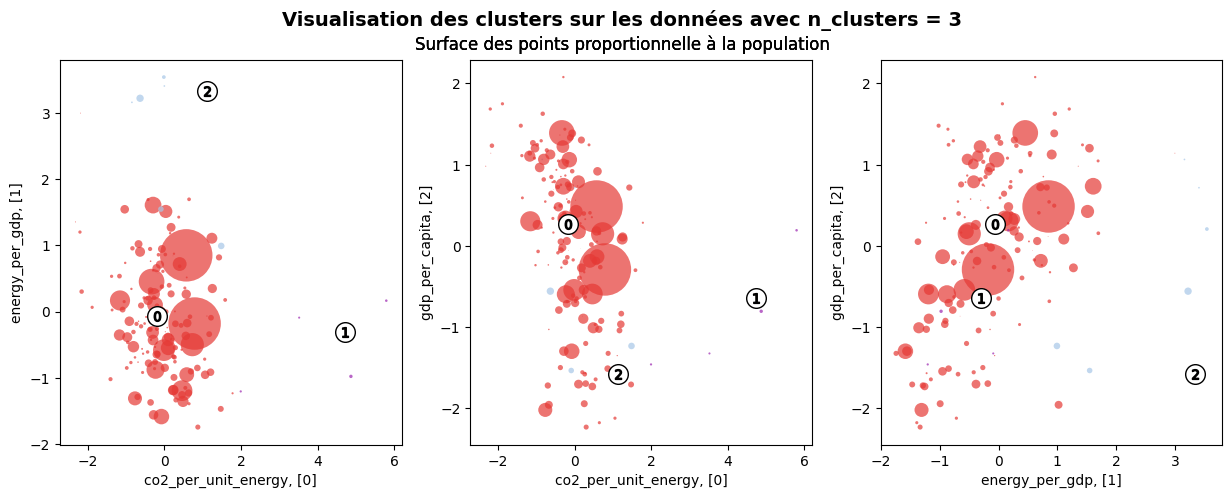

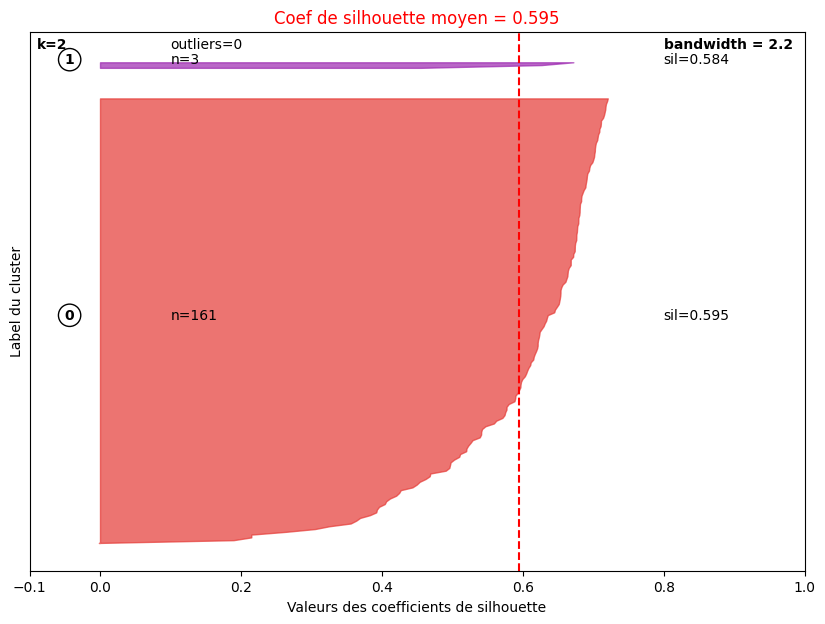

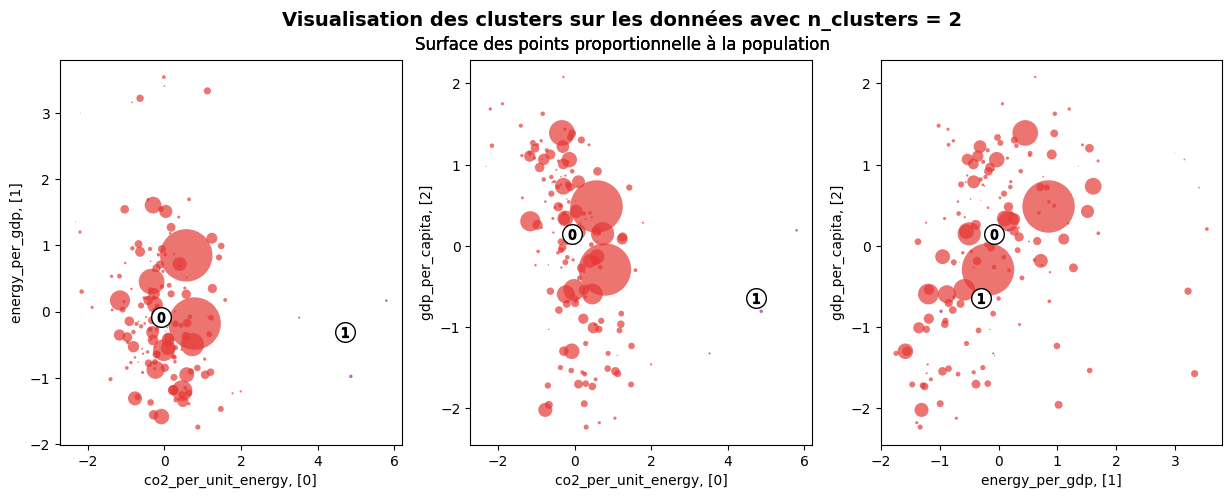

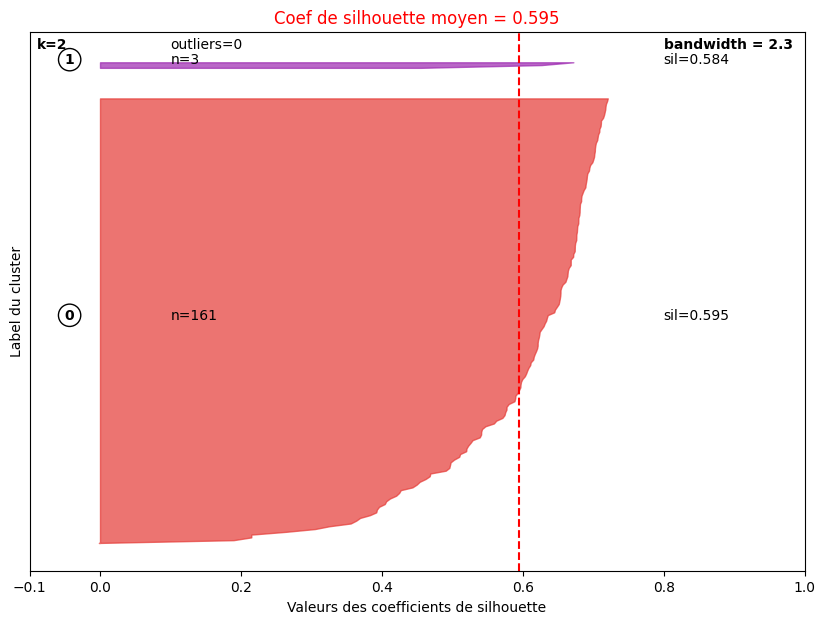

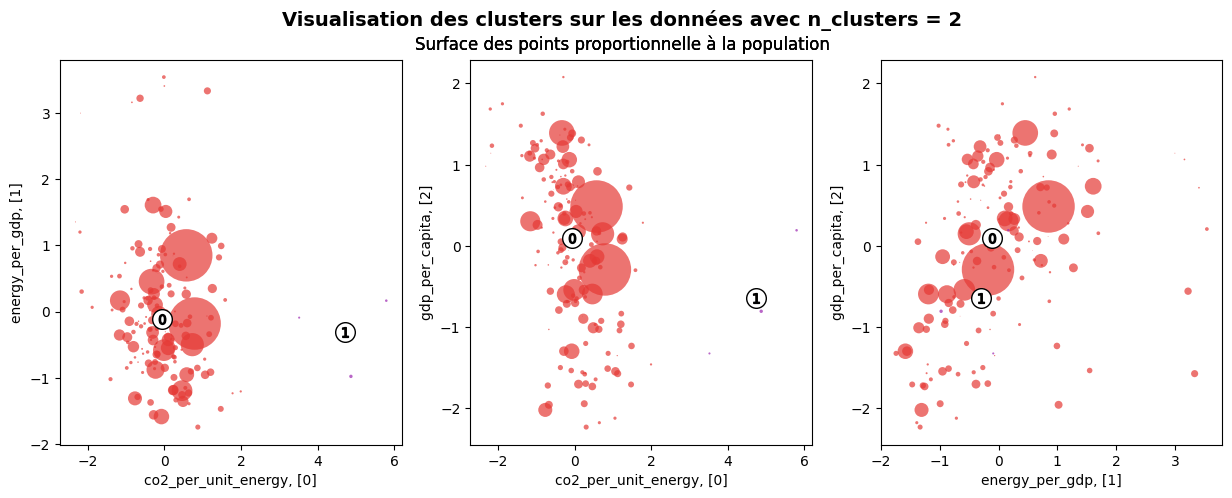

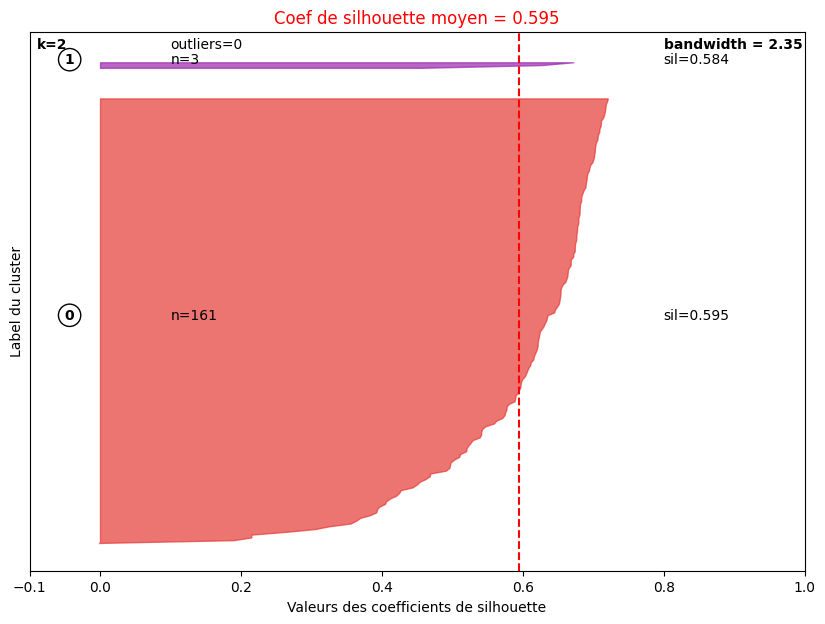

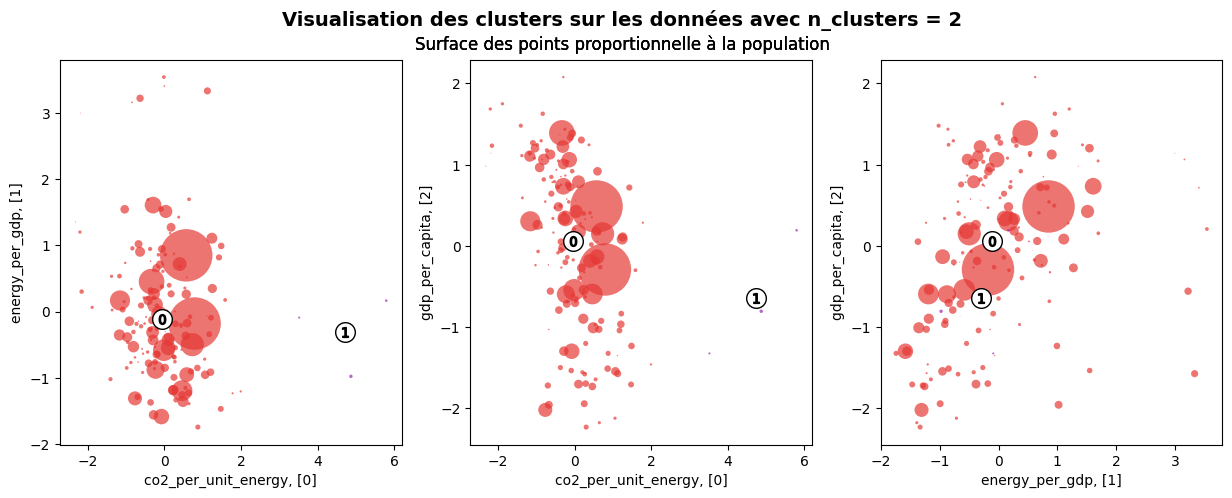

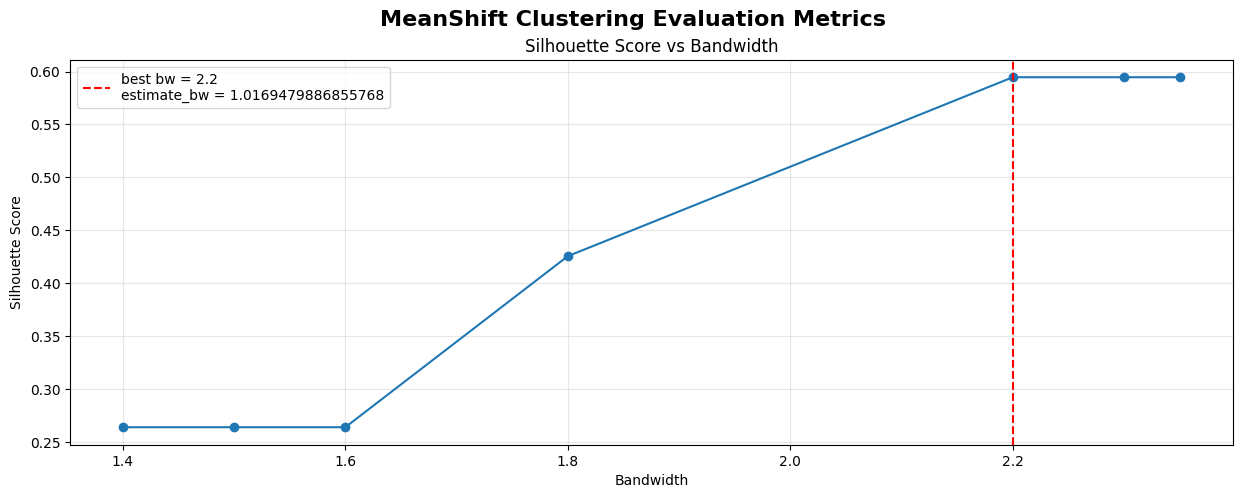

In [15]:
df, X =  preprocessing(df, years, countries, cols, features)
figs = []
silhouette_scores = []
inertia_scores = []
estimate_bw = estimate_bandwidth(X, quantile=0.1)

for bw in bw_values:
   
  ms = MeanShift(bandwidth=bw)
  cluster_labels = ms.fit_predict(X)
  centers = ms.cluster_centers_

  n_clusters = len(set(cluster_labels) - {-1})
  if n_clusters > 0:
      silhouette_avg = silhouette_score(X, cluster_labels)
      silhouette_sample_values = silhouette_samples(X, cluster_labels)
  else:
      silhouette_avg = 0
      silhouette_sample_values = np.zeros(cluster_labels.shape)

  fig1 = display_silhouettes(X, n_clusters, cluster_labels, bw=bw)
  # plotting 2D clusters [optional]


  fig2 = display_clusters(X, n_clusters, features, centers, cluster_labels, df['population'])
  # silhouette_scores.append(silhouette_score(X, cluster_labels))
  silhouette_scores.append(silhouette_avg)  
  

fig = display_scores_ms(bw_values, silhouette_scores, estimate_bw)
figs.append(fig)

   

# 4/ Analyse et conclusion :

### bandwidth > 2.0 : 2 clusters
- un petit cluster correspondant à la variable "co2_per_unit_energy" la plus élevée" (3 points)
- un gros cluster pour les autres points, que le modèle n'arrive pas à clustriser de façon équilibrée

In [16]:
col = "co2_per_unit_energy"
df_2022 = df[df["year"] == 2022]
df_2022[df_2022[col]>0.4]


,country,year,iso_code,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
32,Congo,2022,COG,8.728,1.304985e+10,2.367901e+10,6035104.0,0.669,0.551,3923.546618
84,Lesotho,2022,LSO,2.551,4.819543e+09,4.761723e+09,2286112.0,0.529,1.012,2082.891468
98,Mongolia,2022,MNG,40.443,5.238416e+10,4.480946e+10,3386015.0,0.772,1.169,13233.687161


### bandwidth = 1.8 : 3 clusters 
- un petit cluster correspondant à la variable "co2_per_unit_energy" la plus élevée" (3 points), le même que ci-dessus.
- un petit cluster correspondant à la variable "energy_per_gdp" la plus élevée" (7 points)
- un gros cluster  pour les autres points, que le modèle n'arrive pas à clustriser de façon équilibrée

In [17]:
col = "energy_per_gdp"
df_2022 = df[df["year"] == 2022]
df_2022[df_2022[col]>2.395]

,country,year,iso_code,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
9,Bahrain,2022,BHR,37.827,2.480774e+11,5.876976e+10,1533460.0,0.152,4.221,38324.938489
66,Iceland,2022,ISL,3.598,6.372470e+10,1.601954e+10,380368.0,0.056,3.978,42115.899447
86,Libya,2022,LBY,58.974,2.192983e+11,9.144448e+10,7223804.0,0.269,2.398,12658.771050
110,North Korea,2022,PRK,56.289,1.819134e+11,4.048885e+10,26328843.0,0.309,4.493,1537.813396
148,Trinidad and Tobago,2022,TTO,37.493,1.730529e+11,3.751338e+10,1495923.0,0.217,4.613,25077.082158
151,Turkmenistan,2022,TKM,102.063,4.717938e+11,9.750294e+10,7230197.0,0.216,4.839,13485.517024
159,Venezuela,2022,VEN,108.424,6.460375e+11,1.496821e+11,28213015.0,0.168,4.316,5305.425982
